In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, Resize, PILToTensor, InterpolationMode
from PIL import Image
import torchvision.transforms.functional as TF
from tqdm import tqdm

# TensorBoard Summary Writer.
from torch.utils.tensorboard import SummaryWriter
import datetime

2025-04-16 13:58:43.636889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744811923.870552      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744811923.941336      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
###############################################################################
# 1. Dataset and Model Definitions (Unchanged from your original code)
###############################################################################

class SegmentationDataset(Dataset):
    """
    Dataset for semantic segmentation with classes:
    - 0: background
    - 85: large vehicle
    - 170: two wheeler
    - 255: people
    """
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # Get list of files (assuming images and masks have same names)
        self.images = sorted(os.listdir(image_dir))
        
        # Define class mapping from original pixel values to class indices.
        self.class_values = [0, 85, 170, 255]
        self.class_mapping = {
            0: 0,    # background -> 0
            85: 1,   # large vehicle -> 1
            170: 2,  # two wheeler -> 2
            255: 3   # people -> 3
        }
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image file and corresponding mask file.
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)
        
        # Open image and mask.
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale mask
        
        # Apply transformations if specified.
        if self.transform is not None:
            image = self.transform(image)
            image = image / 225  # Note: if your transform already normalizes, adjust as needed.
            mask = self.transform(mask)
        elif not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)
        
        # Convert the mask to numpy.
        mask_np = np.array(mask)
        
        # Create segmentation mask with class indices.
        segmentation_mask = np.zeros(mask_np.shape, dtype=np.int64)
        for pixel_val, class_idx in self.class_mapping.items():
            segmentation_mask[mask_np == pixel_val] = class_idx
        
        # Convert segmentation mask to tensor.
        segmentation_mask = torch.from_numpy(segmentation_mask).long()
        if segmentation_mask.ndim == 3 and segmentation_mask.size(0) == 1:
            segmentation_mask = segmentation_mask.squeeze(0)
        
        return image, segmentation_mask
    
    def get_class_names(self):
        return ["background", "large vehicle", "two wheeler", "people"]
    
    def get_class_count(self):
        return len(self.class_mapping)

In [4]:
###############################################################################
# 2. Model (UNet) Definition (Unchanged from your original code)
###############################################################################

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=4, features=None):
        """
        UNet architecture for semantic segmentation
        
        Args:
            in_channels (int): Number of input channels (3 for RGB).
            out_channels (int): Number of output classes.
            features (list): List of feature dimensions for each level.
        """
        super(UNet, self).__init__()
        
        if features is None:
            features = [64, 128, 256, 512]
        
        # Encoder (downsampling path)
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder.append(ConvBlock(in_channels, features[0]))
        for i in range(len(features) - 1):
            self.encoder.append(ConvBlock(features[i], features[i + 1]))
        
        # Bottleneck
        self.bottleneck = ConvBlock(features[-1], features[-1] * 2)
        
        # Decoder (upsampling path)
        self.decoder = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        for i in range(len(features))[::-1]:
            self.up_convs.append(
                nn.ConvTranspose2d(
                    features[i] * 2 if i == len(features) - 1 else features[i + 1],
                    features[i],
                    kernel_size=2,
                    stride=2
                )
            )
            self.decoder.append(ConvBlock(features[i] * 2, features[i]))
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for enc in self.encoder[:-1]:
            x = enc(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.encoder[-1](x)
        skip_connections.append(x)
        skip_connections = skip_connections[::-1]
        
        x = self.bottleneck(x)
        for i, (up, dec) in enumerate(zip(self.up_convs, self.decoder)):
            x = up(x)
            skip = skip_connections[i]
            if x.shape != skip.shape:
                x = TF.resize(x, size=skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = dec(x)
        
        return self.final_conv(x)


In [5]:
###############################################################################
# 3. Utility Functions (Mostly Unchanged; minor comments added)
###############################################################################

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    """Save model checkpoint."""
    print(f"=> Saving checkpoint to {filename}")
    torch.save(state, filename)

def load_checkpoint(checkpoint_path, model, optimizer=None):
    """Load model checkpoint."""
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])
    if optimizer is not None and "optimizer" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer"])
    return checkpoint.get("epoch", 0)

def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform=None,
    val_transform=None,
    num_workers=4,
    pin_memory=True,
):
    """
    Create train and validation data loaders.
    """
    train_dataset = SegmentationDataset(
        image_dir=train_dir,
        mask_dir=train_mask_dir,
        transform=train_transform
    )
    
    val_dataset = SegmentationDataset(
        image_dir=val_dir,
        mask_dir=val_mask_dir,
        transform=val_transform
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    
    print(f"Created train loader with {len(train_dataset)} samples")
    print(f"Created validation loader with {len(val_dataset)} samples")
    
    return train_loader, val_loader

def save_random_prediction(model, val_dataset, output_folder, device):
    """
    Selects a random image from the validation dataset, runs it through the model,
    converts the prediction to a grayscale mask with specific pixel mappings, 
    and saves the original image, ground truth mask, and predicted mask.
    
    Filenames:
      - Image:    img_{rand_idx}.png
      - Ground Truth: gt_{rand_idx}.png
      - Prediction:   pred_{rand_idx}.png
    """
    os.makedirs(output_folder, exist_ok=True)
    rand_idx = random.randint(0, len(val_dataset) - 1)
    image, gt = val_dataset[rand_idx]
    
    # Save original image.
    image_np = image.permute(1, 2, 0).cpu().numpy()
    pil_img = Image.fromarray(image_np.astype(np.uint8))
    img_file = os.path.join(output_folder, f"img_{rand_idx}.png")
    pil_img.save(img_file)
    
    # Save ground truth mask.
    mapping = {0: 0, 1: 80, 2: 170, 3: 255}
    gt_np = gt.cpu().numpy()
    mapped_gt = np.zeros_like(gt_np, dtype=np.uint8)
    for cls, pixel_val in mapping.items():
        mapped_gt[gt_np == cls] = pixel_val
    gt_img = Image.fromarray(mapped_gt)
    gt_file = os.path.join(output_folder, f"gt_{rand_idx}.png")
    gt_img.save(gt_file)
    
    # Generate and save prediction.
    image_tensor = image.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)  # Shape: (1, 4, H, W)
    model.train()
    pred_classes = torch.argmax(output, dim=1).squeeze(0)  # Shape: (H, W)
    pred_np = pred_classes.cpu().numpy()
    mapped_pred = np.zeros_like(pred_np, dtype=np.uint8)
    for cls, pixel_val in mapping.items():
        mapped_pred[pred_np == cls] = pixel_val
    pred_img = Image.fromarray(mapped_pred)
    pred_file = os.path.join(output_folder, f"pred_{rand_idx}.png")
    pred_img.save(pred_file)
    
    print(f"Saved image: {img_file}")
    print(f"Saved ground truth: {gt_file}")
    print(f"Saved prediction: {pred_file}")

In [6]:
###############################################################################
# 4. Training, Evaluation (mIoU) and TensorBoard Logging
###############################################################################

# === CHANGED: Evaluate function now computes mIoU instead of pixel accuracy ===
def evaluate_iou(model, loader, device, num_classes=4):
    """
    Evaluate the model on the loader and compute Mean Intersection over Union (mIoU).
    """
    model.eval()
    intersections = [0] * num_classes
    unions = [0] * num_classes

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device)
            outputs = model(data)  # Shape: (N, num_classes, H, W)
            predictions = torch.argmax(outputs, dim=1)  # Shape: (N, H, W)
            
            for cls in range(num_classes):
                pred_inds = (predictions == cls)
                target_inds = (targets == cls)
                intersections[cls] += (pred_inds & target_inds).sum().item()
                unions[cls] += (pred_inds | target_inds).sum().item()

    # Compute IoU for each class and then compute mIoU.
    ious = []
    for cls in range(num_classes):
        if unions[cls] == 0:
            continue
        ious.append(intersections[cls] / unions[cls])
    mean_iou = np.mean(ious) if len(ious) > 0 else 0.0
    model.train()
    return mean_iou

# === CHANGED: train_fn remains mostly the same. ===
def train_fn(loader, model, optimizer, device):
    model.train()
    loss_fn = nn.CrossEntropyLoss()  # Expects (N, C, H, W) output and (N, H, W) target.
    train_loss = 0.0
    loop = tqdm(loader, desc="Training", leave=False)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    avg_loss = train_loss / len(loader)
    return avg_loss

In [ ]:
###############################################################################
# 5. Main Training Loop with TensorBoard Logging, Model Saving on mIoU, and
#    Saving Graphs as Images (Approach 1)
###############################################################################

def main():
    # Device configuration.
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Running on {DEVICE}")
    
    # === CHANGED: TensorBoard Setup added ===
    runs = '/kaggle/working/runs'
    os.makedirs(runs, exist_ok=True)
    log_dir = os.path.join(runs, datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    writer = SummaryWriter(log_dir=log_dir)
    
    # Hyperparameters and paths.
    LEARNING_RATE = 1e-5
    BATCH_SIZE = 16  # If OOM occurs, reduce this.
    NUM_EPOCHS = 40
    NUM_WORKERS = 4
    PIN_MEMORY = True
    
    TRAIN_IMG_DIR = '/kaggle/input/dataset/data/train/images'
    TRAIN_MASK_DIR = '/kaggle/input/dataset/data/train/mask'
    VAL_IMG_DIR = '/kaggle/input/dataset/data/val/images'
    VAL_MASK_DIR = '/kaggle/input/dataset/data/val/mask'
    
    PREDICTIONS_DIR = '/kaggle/working/predictions'
    os.makedirs(PREDICTIONS_DIR, exist_ok=True)
    
    MODEL_SAVE_PATH = '/kaggle/working/model/best_checkpoint.pth'
    os.makedirs('/kaggle/working/model', exist_ok=True)
    
    # Define transforms.
    train_transform = Compose([
        Resize((240, 240), interpolation=InterpolationMode.NEAREST),
        PILToTensor()  # Preserves integer pixel values.
    ])
    val_transform = Compose([
        Resize((240, 240), interpolation=InterpolationMode.NEAREST),
        PILToTensor()  # Preserves integer pixel values.
    ])

    # Create data loaders.
    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR, TRAIN_MASK_DIR,
        VAL_IMG_DIR, VAL_MASK_DIR,
        batch_size=BATCH_SIZE,
        train_transform=train_transform,
        val_transform=val_transform,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    
    # Instantiate the model and move to device.
    model = UNet(in_channels=3, out_channels=4).to(DEVICE)
    
    # Define the optimizer.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    best_val_iou = 0.0  # === CHANGED: Now tracking best mIoU rather than pixel accuracy ===
    
    # === CHANGED: Create lists to track training metrics for later plotting.
    train_loss_history = []
    val_iou_history = []
    
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
        avg_train_loss = train_fn(train_loader, model, optimizer, DEVICE)
        print(f"Average Training Loss: {avg_train_loss:.4f}")
        writer.add_scalar("Train/Loss", avg_train_loss, epoch)  # TensorBoard logging
        
        # Track the training loss.
        train_loss_history.append(avg_train_loss)
        
        # Evaluate the model using mIoU.
        val_iou = evaluate_iou(model, val_loader, DEVICE, num_classes=4)
        print(f"Validation Mean IoU: {val_iou:.8f}")
        writer.add_scalar("Validation/mIoU", val_iou, epoch)  # TensorBoard logging
        
        # Track the mIoU history.
        val_iou_history.append(val_iou)
        
        # === CHANGED: Save model based on mIoU improvement ===
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "val_iou": best_val_iou,
                "epoch": epoch + 1
            }
            save_checkpoint(checkpoint, filename=MODEL_SAVE_PATH)
            print(f"Best model updated with Mean IoU: {best_val_iou:.8f}")
        
        # Save random prediction every 5 epochs.
        if (epoch + 1) % 5 == 0:
            val_dataset = val_loader.dataset
            save_random_prediction(model, val_dataset, PREDICTIONS_DIR, DEVICE)
    
    writer.close()  # Close TensorBoard writer.
    
    # === CHANGED: Plot and save graph images using Matplotlib after training ===
    import matplotlib.pyplot as plt
    epochs_range = list(range(1, NUM_EPOCHS + 1))
    
    # Plot and save the Training Loss curve.
    plt.figure()
    plt.plot(epochs_range, train_loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()
    train_loss_path = os.path.join(PREDICTIONS_DIR, "train_loss.png")
    plt.savefig(train_loss_path)
    plt.close()
    print(f"Training Loss graph saved at: {train_loss_path}")
    
    # Plot and save the Validation mIoU curve.
    plt.figure()
    plt.plot(epochs_range, val_iou_history, label="Validation mIoU", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("mIoU")
    plt.title("Validation mIoU over Epochs")
    plt.legend()
    val_miou_path = os.path.join(PREDICTIONS_DIR, "val_miou.png")
    plt.savefig(val_miou_path)
    plt.close()
    print(f"Validation mIoU graph saved at: {val_miou_path}")
    
    print("Training complete.")

if __name__ == "__main__":
    main()


/tmp/ipykernel_31/3631835143.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Created train loader with 2975 samples
Created validation loader with 500 samples


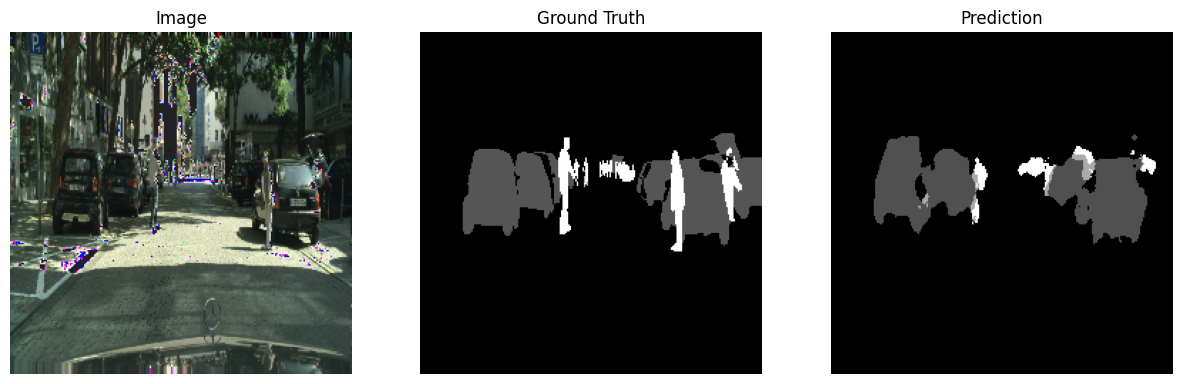

In [13]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Load the saved model ---
# Replace 'YourModelDefinition' with your actual model class.
# Example: model = UNet(in_channels=3, out_channels=4)
model_path = "/kaggle/input/unet2/pytorch/default/1/best_checkpoint(1).pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(model_path, map_location=device)
model = UNet()  
model.load_state_dict(checkpoint["state_dict"])


# Initialize the model (make sure it has the same architecture as when you saved it)
# model = UNet()  
# model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode

train_transform = Compose([
    Resize((240, 240), interpolation=InterpolationMode.NEAREST),
    PILToTensor()  # This preserves integer pixel values.
])

val_transform = Compose([
    Resize((240, 240), interpolation=InterpolationMode.NEAREST),
    PILToTensor()  # This preserves integer pixel values.
])

TRAIN_IMG_DIR = '/kaggle/input/dataset/data/train/images'
TRAIN_MASK_DIR = '/kaggle/input/dataset/data/train/mask'
VAL_IMG_DIR = '/kaggle/input/dataset/data/val/images'
VAL_MASK_DIR = '/kaggle/input/dataset/data/val/mask'
BATCH_SIZE = 4
NUM_WORKERS = 4
PIN_MEMORY = True


train_loader, val_loader = get_loaders(TRAIN_IMG_DIR, TRAIN_MASK_DIR,
                                         VAL_IMG_DIR, VAL_MASK_DIR,
                                         batch_size=BATCH_SIZE,
                                         train_transform=train_transform,
                                         val_transform=val_transform,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=PIN_MEMORY)

# --- Get a sample from your validation dataset ---
# Make sure val_dataset is your validation dataset object that returns (image, ground_truth) pair.
# For example, image might be a tensor of shape [3, H, W] and ground_truth a tensor of shape [H, W] 
# containing class indices (0, 1, 2, 3).
# Choose a sample index (or use random.randint)

val_dataset = val_loader.dataset
image, gt = val_dataset[77]

# --- Run the model to get prediction ---
# Add a batch dimension and move the image to the device.
image_batch = image.unsqueeze(0).to(device)
with torch.no_grad():
    output = model(image_batch)  # expected output shape: [1, 4, H, W]
    
# Remove the batch dimension and take the argmax to get class indices per pixel.
pred_classes = torch.argmax(output, dim=1).squeeze(0).cpu()  # shape: [H, W]

# --- Map class indices to grayscale pixel values ---
# Define your mapping: 
# For example: 0 -> 0, 1 -> 80, 2 -> 170, 3 -> 255.
mapping = {0: 0, 1: 80, 2: 170, 3: 255}

# Helper function to apply mapping to a mask (numpy array).
def map_mask(mask_array, mapping):
    mapped = np.zeros_like(mask_array, dtype=np.uint8)
    for cls, pixel_val in mapping.items():
        mapped[mask_array == cls] = pixel_val
    return mapped

# Ground truth: convert tensor to numpy and map.
gt_np = gt.cpu().numpy() if isinstance(gt, torch.Tensor) else np.array(gt)
#mapped_gt = map_mask(gt_np, mapping)

# Prediction: convert to numpy array and map.
pred_np = pred_classes.numpy()
mapped_pred = map_mask(pred_np, mapping)
# --- Prepare the original image for plotting ---
# If your image came from ToTensor(), its shape is [C, H, W] and its pixel values are in [0, 1].
# Permute dimensions to [H, W, C] and convert to uint8 by scaling to [0, 255].
image_np = image.permute(1, 2, 0).cpu().numpy()
image_np = (image_np * 255).astype(np.uint8)

# --- Plot the image, ground truth mask, and predicted mask side by side ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Image")
plt.axis("off")

plt.subplot(1, 3, 2)
# plt.imshow(mapped_gt, cmap='gray')
plt.imshow(gt_np, cmap='gray')
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(mapped_pred, cmap='gray')
plt.title("Prediction")
plt.axis("off")

plt.show()
